<a href="https://colab.research.google.com/github/AkshayKumar08/VisionQ/blob/main/visual_question_answering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install easy-vqa

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 23.8 MB/s eta 0:00:00


In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import numpy as np
from PIL import Image

In [3]:
from easy_vqa import get_train_questions, get_test_questions

train_questions, train_answers, train_image_ids = get_train_questions()
test_questions, test_answers, test_image_ids = get_test_questions()

print(train_questions[0])
print(train_answers[0])
print(train_image_ids[0])

what is the blue shape?
rectangle
0


In [4]:
from easy_vqa import get_train_image_paths, get_test_image_paths

train_image_paths = get_train_image_paths()
test_image_paths = get_test_image_paths()

print(train_image_paths[0])

/usr/local/lib/python3.10/dist-packages/easy_vqa/data/train/images/0.png


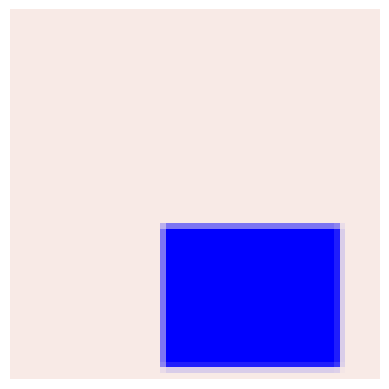

In [5]:
def display_image(image_path):
  try:
    img = mpimg.imread(image_path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()
  except FileNotFoundError:
    print(f"Error: Image file not found at {image_path}")
display_image(train_image_paths[0])

In [6]:
def normalize_image(image_path):
  try:
    img = Image.open(image_path)
    img = img.resize((224, 224))
    img_array = np.array(img) / 255.0
    return img_array
  except FileNotFoundError:
    print(f"Error: Image file not found at {image_path}")
    return None

In [7]:
def read_images(paths):
  ims = {}
  for image_id, image_path in paths.items():
    ims[image_id] = normalize_image(image_path)
  return ims

In [8]:
train_imgs = read_images(train_image_paths)
test_imgs = read_images(test_image_paths)

In [9]:
train_imgs[0].shape

(224, 224, 3)

In [10]:
print(len(train_image_ids))
print(len(train_imgs))

38575
4000


# Dataset

In [14]:
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from transformers import BertModel, BertTokenizer

In [15]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms

class VQADataset(Dataset):
    def __init__(self, image_paths, questions, answers, tokenizer, transform=None):
        self.image_paths = image_paths
        self.questions = questions
        self.answers = answers
        self.tokenizer = tokenizer
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        if self.transform:
            image = self.transform(image)

        question = self.questions[idx]
        inputs = self.tokenizer(question, return_tensors='pt', padding='max_length', truncation=True, max_length=32)
        label = self.answers[idx]
        return image, inputs['input_ids'].squeeze(0), inputs['attention_mask'].squeeze(0), label

In [16]:
class VQAModel(nn.Module):
    def __init__(self, num_classes):
        super(VQAModel, self).__init__()
        self.cnn = models.mobilenet_v3_small(pretrained=True).features
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.input_size = 576 + 768
        self.fc1 = nn.Linear(self.input_size, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, images, questions):
        # Extract image features
        image_features = self.cnn(images)
        image_features = image_features.view(image_features.size(0), -1)  # Flatten

        # Get BERT question embeddings
        question_outputs = self.bert(questions)
        question_features = question_outputs.pooler_output

        # Combine features
        combined_features = torch.cat((image_features, question_features), dim=1)

        # Init last layers
        x = self.fc1(combined_features)
        x = self.dropout(x)
        x = nn.ReLU()(x)
        x = self.fc2(x)
        x = self.dropout(x)
        x = nn.ReLU()(x)
        logits = self.fc3(x)

        return logits

In [17]:
from torch.utils.data import DataLoader
from sklearn.preprocessing import LabelEncoder

In [18]:
# Step 1: Encode answers into labels
label_encoder = LabelEncoder()
encoded_answers = label_encoder.fit_transform(train_answers)
num_classes = len(label_encoder.classes_)

# Step 2: Initialize tokenizer and transformations
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
transform = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.ToTensor(),
])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [19]:
import torch
from torch.utils.data import random_split

full_dataset = VQADataset(train_image_paths, train_questions, encoded_answers, tokenizer, transform)

torch.manual_seed(42)

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

# Split the dataset
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print(f'Training set size: {len(train_dataset)}')
print(f'Validation set size: {len(val_dataset)}')

Training set size: 3200
Validation set size: 800


In [20]:
model = VQAModel(num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-5)

def calculate_accuracy(logits, labels):
    _, predicted = torch.max(logits, 1)
    return (predicted == labels).float().mean().item()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth
100%|██████████| 9.83M/9.83M [00:00<00:00, 38.2MB/s]


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [21]:
num_epochs = 3

for epoch in range(num_epochs):
  # Train
    model.train()
    total_train_loss = 0
    total_train_accuracy = 0

    for images, input_ids, attention_mask, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images, input_ids)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        total_train_accuracy += calculate_accuracy(outputs, labels)

    avg_train_loss = total_train_loss / len(train_loader)
    avg_train_accuracy = total_train_accuracy / len(train_loader)

    print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, Training Accuracy: {avg_train_accuracy:.4f}')

    # Validation
    model.eval()
    total_val_loss = 0
    total_val_accuracy = 0

    with torch.no_grad():
        for images, input_ids, attention_mask, labels in val_loader:
            outputs = model(images, input_ids)
            loss = criterion(outputs, labels)

            total_val_loss += loss.item()
            total_val_accuracy += calculate_accuracy(outputs, labels)

    avg_val_loss = total_val_loss / len(val_loader)
    avg_val_accuracy = total_val_accuracy / len(val_loader)

    print(f'Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {avg_val_accuracy:.4f}')

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Epoch [1/3], Training Loss: 1.6317, Training Accuracy: 0.4703
Epoch [1/3], Validation Loss: 1.1043, Validation Accuracy: 0.6538
Epoch [2/3], Training Loss: 1.0386, Training Accuracy: 0.6516
Epoch [2/3], Validation Loss: 0.9407, Validation Accuracy: 0.6675
Epoch [3/3], Training Loss: 0.9035, Training Accuracy: 0.6672
Epoch [3/3], Validation Loss: 0.9135, Validation Accuracy: 0.6613


In [35]:
encoded_answers = label_encoder.fit_transform(test_answers)

test_dataset = VQADataset(test_image_paths, test_questions, encoded_answers, tokenizer, transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [45]:
correct_predictions = 0
total_predictions = len(predictions)

for i in range(total_predictions):
    if predictions[i] == encoded_answers[i]:
        correct_predictions += 1

accuracy = correct_predictions / total_predictions
print(f"Accuracy: {accuracy}")

Accuracy: 0.654


In [23]:
import torch
from PIL import Image
from torchvision import transforms

def predict_single_image(image_path, question, model, tokenizer, label_encoder):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)

    inputs = tokenizer(question, return_tensors='pt', padding='max_length', truncation=True, max_length=32)

    image = image.to(next(model.parameters()).device)
    input_ids = inputs['input_ids'].to(next(model.parameters()).device)

    model.eval()
    with torch.no_grad():
        logits = model(image, input_ids)
        prediction = torch.argmax(logits, dim=1)
        predicted_label = label_encoder.inverse_transform([prediction.item()])

    plt.imshow(image.cpu().squeeze(0).numpy().transpose(1, 2, 0))
    plt.axis('off')
    plt.title(f'Question: {question}\nPrediction: {predicted_label[0]}')
    plt.show()

    return predicted_label[0]

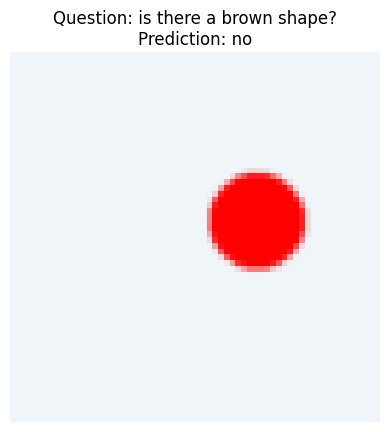

Predicted Answer: no


In [44]:
image_index = 10
image_path = test_image_paths[image_index]
question = test_questions[image_index]

predicted_answer = predict_single_image(image_path, question, model, tokenizer, label_encoder)
print(f'Predicted Answer: {predicted_answer}')